In [1]:
import glob
import math
import pathlib
import datetime

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import albumentations as A
import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras
from keras import layers

# set random seed for reproductibility
random_seed = 0
np.random.seed(random_seed)

try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

2022-08-26 09:29:40.140865: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Segmentation Models: using `keras` framework.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-bbd6bfc6-bff1-827c-28a7-86da63e1b953)


## Fonctions communes

In [6]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title(f_loss.name.title())
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot metric
    plt.subplot(212)
    plt.title('IoU scores')
    plt.plot(history.history['iou_score'], color='blue', label='train')
    plt.plot(history.history['val_iou_score'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

### DataGenerator

In [7]:
class CustomDataGenerator(keras.utils.Sequence):
    # We use Sequence as parent class, because Sequence are a safer way to do multiprocessing.
    # This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.
    
    def __init__(self, datapath, batch_size, augmentation=None, preprocessing=None, shuffle=False, verbose=0, maxbatches=None, *args, **kwargs):
        self.batch_size = batch_size
        self.ids = [x[:-4] for x in glob.glob(f"{datapath}/*[!_labels].png")]
        self.shuffle = shuffle
        self.verbose = verbose
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.maxbatches = maxbatches
        #print(len(self.ids), self.ids)
        
    def __len__(self):
        # returns the number of batches
        if self.maxbatches:
            return min(self.maxbatches, math.ceil(len(self.ids) / self.batch_size))
        else:
            return math.ceil(len(self.ids) / self.batch_size)
    
    def __getitem__(self, index):
        # returns one batch
        
        since = index * self.batch_size
        until = (index+1) * self.batch_size
        batch_ids = self.ids[since:until]
        
        images = []
        labels = []
        for source_id in batch_ids:
            if self.verbose > 0:
                print(source_id)
            
            x = np.array(Image.open(f"{source_id}.png"))            
            y = np.array(Image.open(f"{source_id}_labels.png"))
            
            if self.augmentation:
                augmented = self.augmentation(image=x, mask=y)
                x, y = augmented['image'], augmented['mask']
                
            if self.preprocessing:
                x = self.preprocessing(x)
              
            images.append(x/255.0) # normalize between 0 and 1 at the same time
            #labels.append(y)
            labels.append(keras.utils.to_categorical(y, 8))
         
        return np.array(images, dtype=float), np.array(labels, dtype=float)
        
    def on_epoch_end(self):
        # logics run once at the very beginning and then at the end of each epoch
        if self.shuffle:
            return np.random.shuffle(self.ids) # /!\ Is this really a good idea ????

### Callbacks

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.keras")
    checkpoint = ModelCheckpoint(
        monitor="val_iou_score",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        verbose=1,
    )
    
    # Define TensorBoard logging
    log_dir = f"logs/fit/{model_name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M')}"
    tensorboard = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
    )
    
    # Define Learning-Rate modification conditions
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=4,
        # min_lr=0.001,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=9,
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )
    
    return [checkpoint, es, reduce_lr, tensorboard]

# Modèle de référence

### Préparons les training et validation sets **sans** data-augmentation

In [9]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=None, # Pas d'augementations pour la baseline
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons notre modèle de référence
> https://keras.io/examples/vision/oxford_pets_image_segmentation/

In [10]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [12]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# f_loss = sm.losses.bce_jaccard_loss
f_metrics = [sm.metrics.iou_score]

#model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
#model = unet_base(input_size=(128,256,3))
model = get_model((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss, # sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [14]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks("U-Net - baseline"),
    # validation_split=0.2
)

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.6412 - iou_score: 0.4052
Epoch 1: val_iou_score improved from -inf to 0.10150, saving model to models/U-Net - baseline.keras
372/372 [==============================] - 30s 81ms/step - loss: 0.6412 - iou_score: 0.4052 - val_loss: 2.0057 - val_iou_score: 0.1015 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.5191 - iou_score: 0.4562
Epoch 2: val_iou_score improved from 0.10150 to 0.42674, saving model to models/U-Net - baseline.keras
372/372 [==============================] - 28s 74ms/step - loss: 0.5191 - iou_score: 0.4562 - val_loss: 0.6115 - val_iou_score: 0.4267 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.4773 - iou_score: 0.4774
Epoch 3: val_iou_score improved from 0.42674 to 0.43521, saving model to models/U-Net - baseline.keras
372/372 [==============================] - 27s 74ms/step - loss: 0.4773 - iou_score: 0.4774 - va

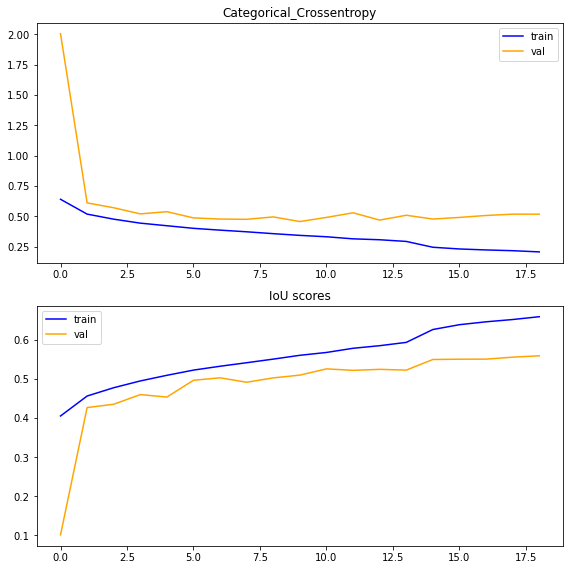

In [15]:
summarize_diagnostics(history)

# Modèle de référence (avec augmentation des données)

### Préparons les training et validation sets **avec** data-augmentation

In [16]:
transform1 = A.Compose([
    # A.RandomCrop(width=100, height=100),
    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    A.Rotate(15, p=0.5),
    # A.Transpose(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    # A.Blur(p=0.01, blur_limit = 3),
    # A.OneOf([
    #        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    #        A.GridDistortion(p=0.5),
    #        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    # ], p=0.5)
])

In [17]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform1,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

In [18]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# f_loss = sm.losses.bce_jaccard_loss
f_metrics = [sm.metrics.iou_score]

model = get_model((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss, # sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [19]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks("U-Net - baseline + data-augmentation"),
    # validation_split=0.2
)

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.8936 - iou_score: 0.3420
Epoch 1: val_iou_score improved from -inf to 0.04173, saving model to models/U-Net - baseline + data-augmentation.keras
372/372 [==============================] - 30s 76ms/step - loss: 0.8936 - iou_score: 0.3420 - val_loss: 2.9097 - val_iou_score: 0.0417 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.6277 - iou_score: 0.3968
Epoch 2: val_iou_score improved from 0.04173 to 0.41093, saving model to models/U-Net - baseline + data-augmentation.keras
372/372 [==============================] - 28s 75ms/step - loss: 0.6277 - iou_score: 0.3968 - val_loss: 0.6040 - val_iou_score: 0.4109 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.5802 - iou_score: 0.4173
Epoch 3: val_iou_score improved from 0.41093 to 0.43352, saving model to models/U-Net - baseline + data-augmentation.keras
372/372 [===========================

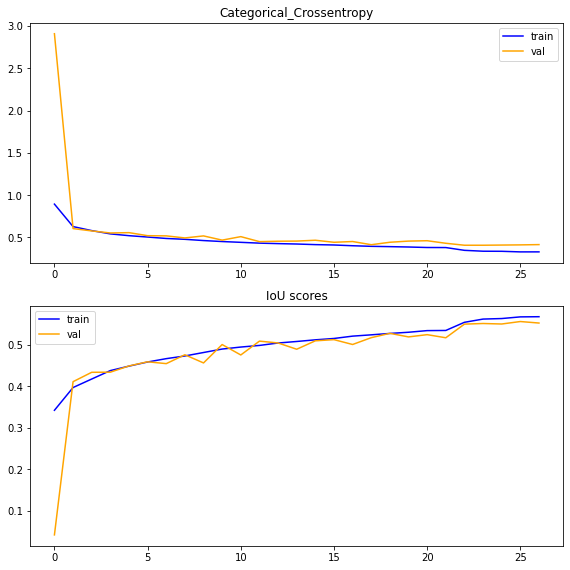

In [20]:
summarize_diagnostics(history)

In [21]:
import FreeMobileSMS as sms
sms.send("Finished")

JupyterScriptCompleted: Finished

# Modèle autre

### Définissons un pré-processing

In [ ]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Préparons les training et validation sets avec notre CustomDataGenerator

In [ ]:
transform1 = A.Compose([
    # A.RandomCrop(width=100, height=100),
    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    A.Rotate(15, p=0.5),
    # A.Transpose(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(p=0.01, blur_limit = 3),
    # A.OneOf([
    #        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    #        A.GridDistortion(p=0.5),
    #        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    # ], p=0.5)
])

In [ ]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=None, # Pas d'augementations pour la baseline
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    maxbatches=100,
)

### Définissons et entrainons un modèle

In [ ]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# f_loss = sm.losses.bce_jaccard_loss
f_metrics = [sm.metrics.iou_score]

model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(
    optimizer=f_opti,
    loss=f_loss, # sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=5,
    batch_size=batch_size,
    callbacks=init_callbacks("Unet - baseline"),
    # validation_split=0.2
)

In [ ]:
summarize_diagnostics(history)